In [25]:
from utils import CustomDataset, SentencePairClassifier, test_prediction, compute_metric, plot_graph
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import pandas as pd
from datetime import datetime
import configparser
from matplotlib import pyplot as plt
import os.path as path

In [14]:
def compute_metric(labels_test, probs_test, filename):
    metric = {'mean_absolute_error': metrics.mean_absolute_error(labels_test, probs_test), 
        'mean_squared_error': metrics.mean_squared_error(labels_test, probs_test), 
        'mean_absolute_percentage_error': metrics.mean_absolute_percentage_error(labels_test, probs_test),
           'r2_score': metrics.r2_score(labels_test, probs_test)} 
   
    # create series from dictionary 
    metric = pd.Series(metric) 
    metric.to_csv(filename, index=True)

    
def plot_graph(bert_model, normalize, labels_test, probs_test, filename):
    plt.title(bert_model + " " + normalize) 
    plt.plot(labels_test, 'o')
    plt.plot(probs_test, 'o')
    plt.legend(["true", "pred"])
    plt.grid()
    plt.savefig(filename, bbox_inches='tight')


In [15]:
print("load parameters")
config = configparser.ConfigParser()
config.read('parameter.ini')
parameters =  config['parameters']
    
summarize_question = parameters.getboolean('summarize_question')
summarize_answer = parameters.getboolean('summarize_answer')
normalize = parameters.get('normalize')
bert_model = parameters.get('bert_model')    
freeze_bert = parameters.getboolean('freeze_bert') # if True, freeze the encoder weights and only update the classification layer weights
maxlen = parameters.getint('maxlen') 
bs = parameters.getint('bs')  # batch size
iters_to_accumulate = parameters.getint('iters_to_accumulate')  # the gradient accumulation adds gradients over an effective batch of size : bs * iters_to_accumulate. If set to "1", you get the usual batch size
lr = parameters.getfloat('lr')  # learning rate
epochs = parameters.getint('epochs')  # number of training epochs


load parameters


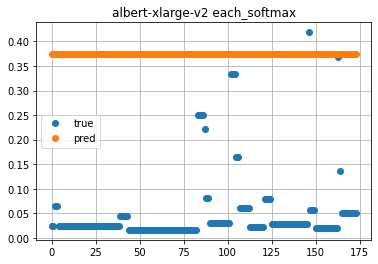

In [16]:
path_to_text_file = f'results/{normalize}_test.txt'  # path to the file with test_df probabilities
path_to_output_file = f'results/{normalize}_output.txt'  # path to the file with prediction probabilities

summarize = any((summarize_question, summarize_answer))
labels_test = pd.read_csv(path_to_text_file, header=None)[0]  # true labels
probs_test = pd.read_csv(path_to_output_file, header=None)[0]  # prediction probabilities
filename = f"{datetime.today().strftime('%Y-%m-%d')}_{bert_model}_{normalize}_summarize_is_{summarize}"

compute_metric(labels_test,probs_test, filename)
plot_graph(bert_model, normalize, labels_test, probs_test, filename)

In [30]:
print("Predicting on test data...")

df_test = "df_test.csv"
test_set = CustomDataset(df_test, maxlen, bert_model)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=5)

Predicting on test data...


In [31]:
model = SentencePairClassifier(bert_model)
if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path_to_model = "models/albert-xlarge-v2_lr_2e-05_val_loss_0.495_ep_2.pt"
model.load_state_dict(torch.load(path_to_model))
model.to(device)

path_to_output_file = f'results/{normalize}_output.txt'

test_prediction(net=model, device=device, dataloader=test_loader, with_labels=True,  # set the with_labels parameter to False if your want to get predictions on a dataset without labels
                result_file=path_to_output_file)


labels_test = pd.read_csv(path_to_text_file, header=None)[0]  # true labels
probs_test = pd.read_csv(path_to_output_file, header=None)[0]  # prediction probabilities
filename = f"fyp/comment_ranking_model/results/{datetime.today().strftime('%Y-%m-%d')}_{bert_model}_{normalize}_summarize_is_{summarize}"
    
compute_metric(labels_test,probs_test, filename)
plot_graph(bert_model, normalize, labels_test, probs_test, filename)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.